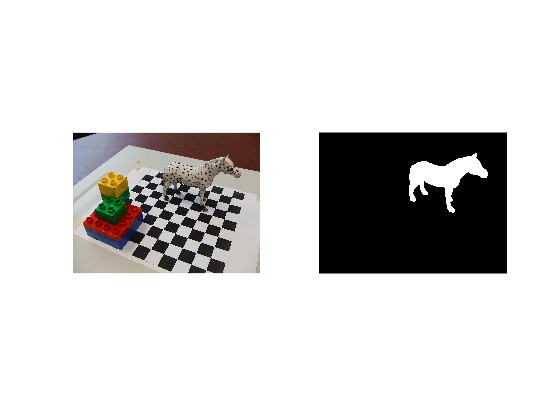

In [1]:
names = dir(fullfile('data','*.jpg'));
maskNames = {};
imgNames = {};
masks = {};
imgs = {};
addpath('data/');
for k = 1:length(names)
    fname = names(k).name;
    if contains(fname, 'Mask')
        maskNames{end + 1} = fname;
        masks{end + 1} = imread(fname);
    else
        imgNames{end + 1} = fname;
        imgs{end + 1} = imread(fname);
    end
end

subplot(1, 2, 1);
imshow(imgs{1});
subplot(1, 2, 2);
imshow(masks{1});

In [2]:
addpath('vlfeat/');
run('vlfeat/toolbox/vl_setup');
addpath('func/');

# Part 1

In [3]:
%%file func/maskFilt.m
function matches = maskFilt(mask, x, y)
    img = zeros(size(mask));
    for i = 1:size(x, 2)
        img(round(y(:, i)), round(x(:, i))) = i;
    end
    img(mask == 0) = 0;
    matches = img(img ~= 0);
end

Created file '/Users/zengs/Documents/Code/VisualComp/HW3/func/maskFilt.m'.


In [4]:
%%file func/matchPts.m
function [matches, scores] = matchPts(imgs, masks, a, b, N, drawFlag)
    addpath('func/');
    [fa, da] = vl_sift(im2single(rgb2gray(imgs{a})));
    [fb, db] = vl_sift(im2single(rgb2gray(imgs{b})));
    [matches, scores] = vl_ubcmatch(da, db);
    [drop, perm] = sort(scores, 'descend');
    perm = perm(1:N);
    matches = matches(:, perm);
    scores = scores(perm);

    xa = fa(1, matches(1, :));
    xb = fb(1, matches(2, :)) + size(imgs{a}, 2);
    ya = fa(2, matches(1, :));
    yb = fb(2, matches(2, :));

    perma = maskFilt(masks{a}, xa, ya);
    permb = maskFilt(masks{b}, xb - size(imgs{a}, 2), yb);
    perm = intersect(perma, permb);
    matches = matches(:, perm);

    if drawFlag
        figure;
        clf;
        imagesc(cat(2, imgs{a}, imgs{b}));

        xa = xa(:, perm);
        xb = xb(:, perm);
        ya = ya(:, perm);
        yb = yb(:, perm);

        hold on ;
        h = line([xa; xb], [ya; yb]);
        set(h, 'linewidth', 1, 'color', 'b');
        vl_plotframe(fa(:, matches(1, :))) ;
        fb(1, :) = fb(1, :) + size(imgs{a}, 2) ;
        vl_plotframe(fb(:, matches(2, :))) ;
        axis image off;
    end
end

Created file '/Users/zengs/Documents/Code/VisualComp/HW3/func/matchPts.m'.


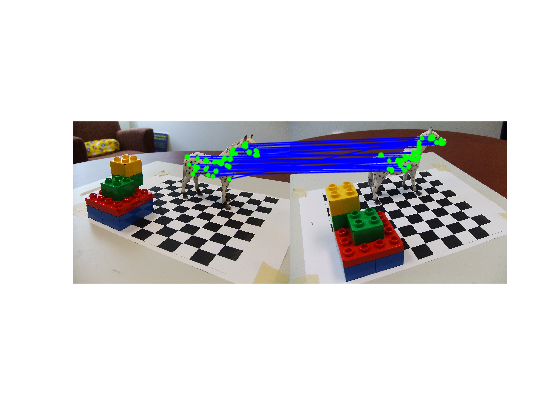

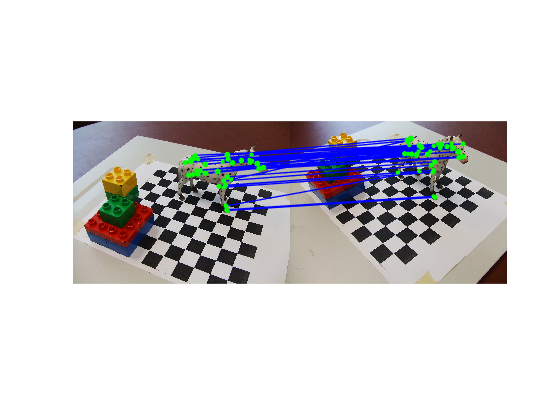

In [5]:
[matches, scores] = matchPts(imgs, masks, 1, 2, 150, true);
[matches, scores] = matchPts(imgs, masks, 3, 4, 150, true);

# Part 2

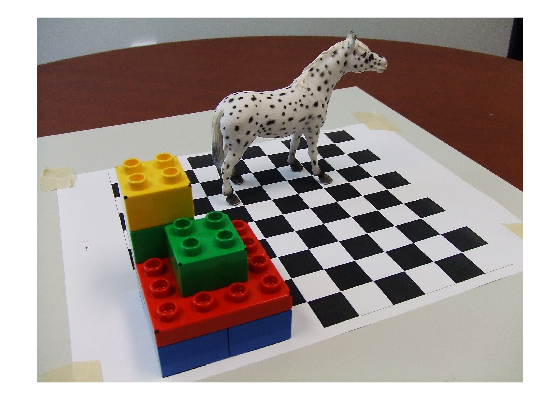

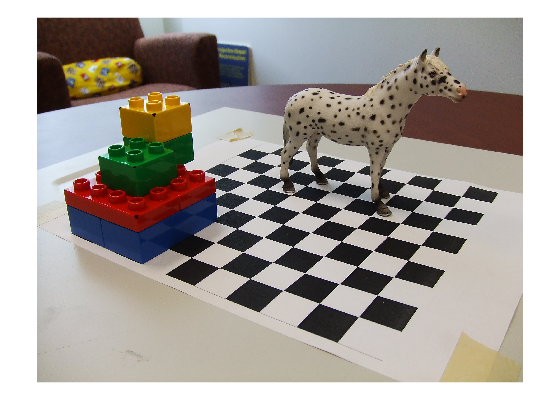

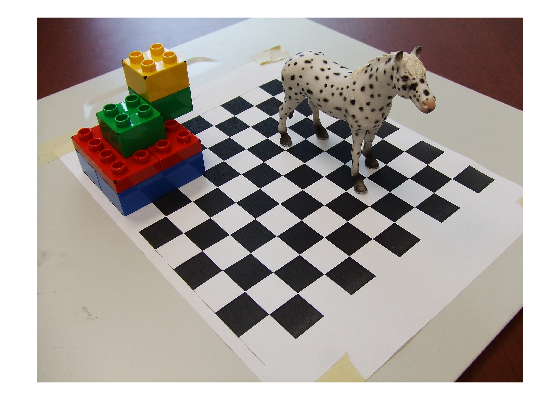

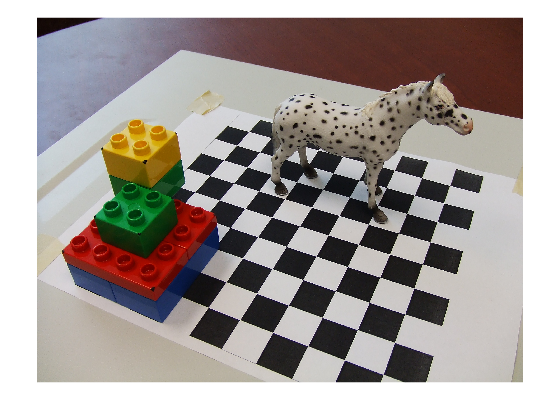

In [6]:
pts3 =[...
    [[0 0 0];[64 0 0];[64 64 0];[0 64 0]]; ... %blue bottom
    %[[0 0 19];[64 0 19];[64 64 19];[0 64 19]]; ... %blue top / red bottom
    [[0 0 29];[64 0 29];[64 64 29];[0 64 29]]; ... %red top
    %[[16 16 29];[48 16 29];[48 48 29];[16 48 29]]; ... %red top / center green bottom
    [[16 16 48];[48 16 48];[48 48 48];[16 48 48]]; ... %center green top
    %[[0 48 29];[32 48 29];[32 80 29];[0 80 29]]; ... %corner green bottom
    [[0 48 48];[32 48 48];[32 80 48];[0 80 48]]; ... %corner green top/ yellow bottom
    [[0 48 67];[32 48 67];[32 80 67];[0 80 67]]; ... %yellow top
    [[20 20 0]; [180 20 0]; [180 180 0]; [20 180 0]] ... %checkboard corner
];

visib1 = [...
    1 1 1 0; ... %blue
%     1 1 1 0; ... %blue/red
    1 1 1 0; ... %red
%     0 0 0 0; ... %red/gren
    1 1 1 0; ... %green
%     0 0 1 0; ... %green
    1 0 1 0; ... %green/yellow
    1 1 1 0; ... %yellow
    0 1 1 1 ... %corners
];

visib2 = [...
    1 1 1 0; ... %blue
%     1 1 1 0; ... %blue/red
    1 1 1 0; ... %red
%     0 0 0 0; ... %red/gren
    1 1 1 0; ... %green
%     0 0 1 0; ... %green
    1 0 1 0; ... %green/yellow
    1 1 1 0; ... %yellow
    0 1 1 0 ... %corners
];

visib3 = [...
    1 1 1 0; ... %blue
%     1 1 1 0; ... %blue/red
    1 1 1 0; ... %red
%     0 0 0 0; ... %red/gren
    1 1 1 0; ... %green
%     0 0 1 0; ... %green
    1 0 1 0; ... %green/yellow
    1 1 1 0; ... %yellow
    0 1 1 1 ... %corners
];

visib4 = [...
    1 1 0 0; ... %blue
%     1 1 1 0; ... %blue/red
    1 1 0 0; ... %red
%     0 0 0 0; ... %red/gren
    1 1 0 1; ... %green
%     0 0 1 0; ... %green
    1 0 0 0; ... %green/yellow
    1 1 0 1; ... %yellow
    0 1 1 0 ... %corners
];

visib = {visib1, visib2, visib3, visib4};
for i = 1:4
    figure, imshow(imgs{i});
end

In [7]:
%%file func/getPts.m
function [pts2] = getPts(img, visib, i)
    addpath('data');
    fname = strcat('data/calib', num2str(i), '.mat');
    if isfile(fname)
        load(fname);
        pts2 = [x, y];
    else
        im = im2single(rgb2gray(img));
        numcorner = sum(visib(:));
        figure, imshow(im);
        title(num2str(numcorner));
        hold on;
        [x, y] = ginput(numcorner);
        hold off;
        pts2 = [x, y];
        filename = strcat("data/calib", num2str(i), ".mat");
        save(filename, 'x', 'y');
    end
end

Created file '/Users/zengs/Documents/Code/VisualComp/HW3/func/getPts.m'.


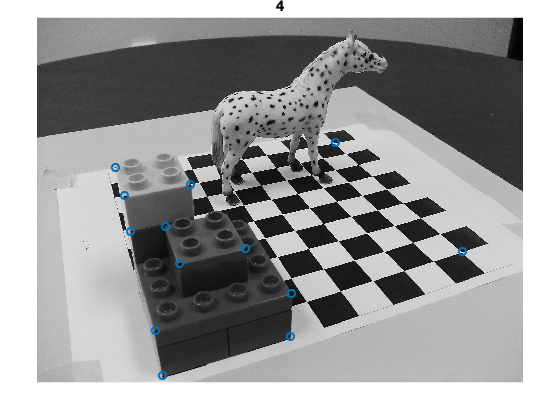

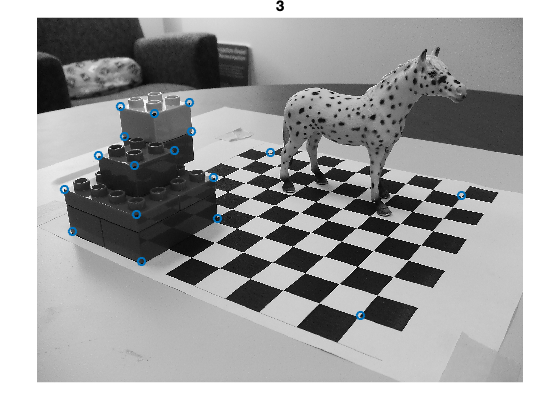

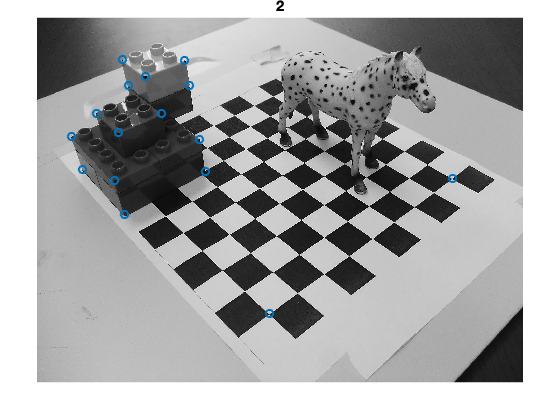

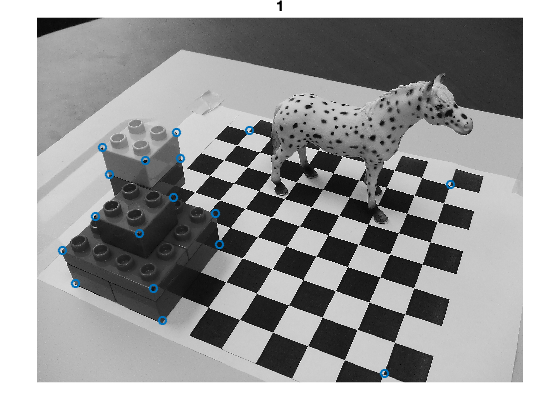

In [8]:
pts2 = {};
n = 4;
for i = 1:n
    pts2{end + 1} = getPts(imgs{i}, visib{i}, i);
    figure, imshow(rgb2gray(imgs{i}));
    title(num2str(i));
    hold on;
    scatter(pts2{i}(:, 1), pts2{i}(:, 2));
    hold off;
    drawnow;
end

In [9]:
%%file func/calibrate.m
function [K, R, t] = calibrate(pts3, pts2, visibs, i)
    addpath('func');
    visib = visibs{i};
    [r, c] = size(corner);
    visib = transpose(reshape(transpose(visib), [1, r * c]));
    perm = nonzeros(visib .* reshape([1:r * c], [r * c, 1]));
    pts3 = pts3(perm, :);

    N = size(pts3, 1);
    p = [pts3, ones(N, 1)];
    A = zeros(N, 24);
    A(:, 5:8) = -p;
    A(:, 9:12) = p .* pts2{i}(:, 2);
    A(:, 13:16) = p;
    A(:, 21:24) = -p .* pts2{i}(:, 1);
    A = transpose(reshape(transpose(A), [12, 2 * N]));
    [U, S, V] = svd(A, 0);
    C = V(:, end);
    C = transpose(reshape(transpose(C), [4, 3]));
    C1 = C(:, 1:3);
    C2 = C(:, 4);
    t = -inv(C1)* C2;
    [R, inK] = qr(inv(C1));
    K = inv(inK);
    K = K / K(end, end);
    D = diag(sign(diag(K)));
    K = K * D;
    R = D * R;
    t = D * t;
    
    t = det(R) * t;
    R = transpose(det(R) * R);
end

Created file '/Users/zengs/Documents/Code/VisualComp/HW3/func/calibrate.m'.


In [11]:
for i = 1:n
    disp(i);
    disp("***********");
    [K, R, t] = calibrate(pts3, pts2, visib, i);
    disp(K);
    disp(R);
    disp(t);
    disp("***********");
end

     1

***********
   1.0e+03 *

    3.2874    0.0618    1.3399
         0    3.2685    0.7490
         0         0    0.0010

    0.8864   -0.4599   -0.0533
   -0.2344   -0.5451    0.8049
   -0.3992   -0.7010   -0.5910

 -215.2358
 -136.1004
 -257.3050

***********
     2

***********
   1.0e+03 *

    2.8487    0.0087    1.0669
         0    2.8810    0.9980
         0         0    0.0010

    0.6032   -0.7938   -0.0781
   -0.4828   -0.4413    0.7564
   -0.6349   -0.4185   -0.6494

 -292.2188
  -75.8975
 -212.6538

***********
     3

***********
   1.0e+03 *

    3.0873    0.0896    1.3043
         0    3.0976    0.6544
         0         0    0.0010

    0.8025   -0.5957   -0.0345
   -0.1442   -0.2498    0.9575
   -0.5790   -0.7634   -0.2863

 -270.6322
 -160.8430
 -148.2678

***********
     4

***********
   1.0e+03 *

    2.8038   -0.0697    1.1901
         0    2.8909    1.3338
         0         0    0.0010

    0.9442    0.3231   -0.0634
    0.2426   -0.5527    0.7973
    0.